c:\Users\AlbinXavier\personal\gowtham\nz-tourism\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\AlbinXavier\personal\gowtham\nz-tourism\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\AlbinXavier\personal\gowtham\nz-tourism\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\AlbinXavier\personal\gowtham\nz-tourism\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been pro


[Hold-out] 2024-08-31 → 2025-07-31 | lags=3 | AIC=-4.537

Arrivals
  RMSE : 26,362.338
  MAE  : 20,989.292
  MAPE : 6.694%
  sMAPE: 6.950%

[VAR] lags=3 | AIC=-4.571 | train=1998-01-31→2025-07-31

Forecast results saved to: ../output/Model_04_VAR_IT_ArrivalCount.csv


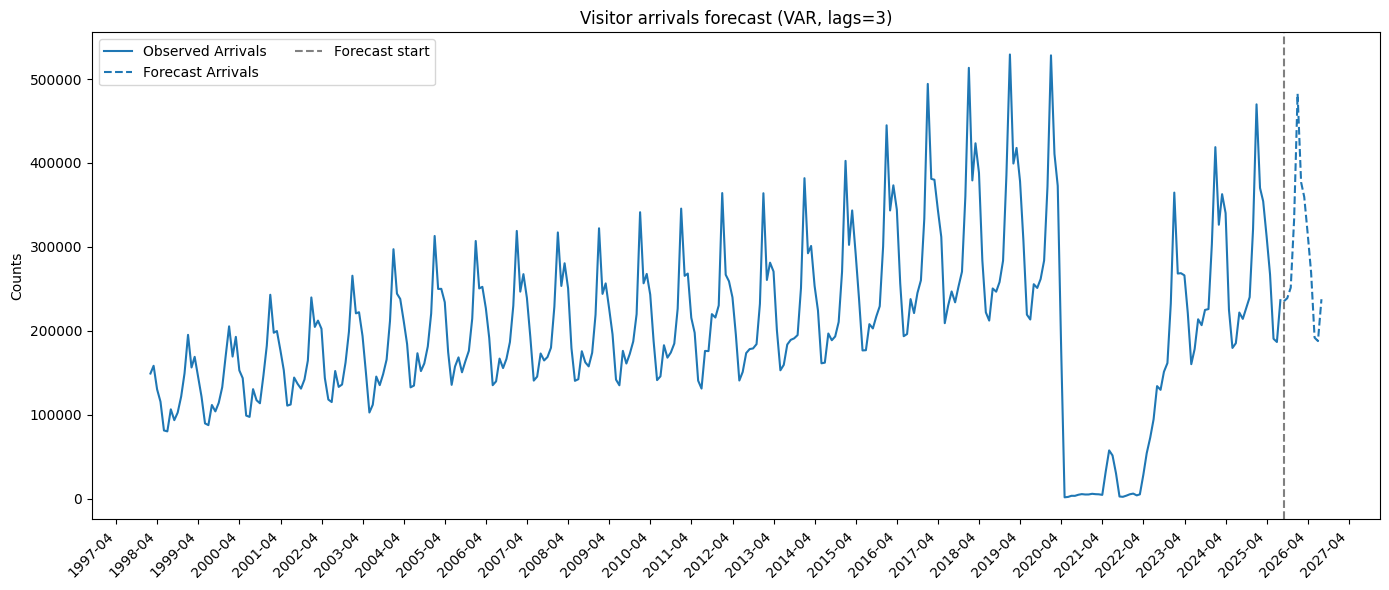

In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pandas.tseries.offsets import MonthEnd
from statsmodels.tsa.api import VAR

# ----------------------- Config -----------------------
ARRIVALS_CSV = "../datasets/Visitor arrival totals (Monthly).csv"

HORIZON = 12
MAX_LAGS = 6
HOLDOUT_STEPS = 12

# Training window (truncate / exclude ranges)
EXCLUDE_RANGES = [
    ("2020-04-30", "2022-02-28"),  # drop COVID border closure period
]

# Companion construction
COMPANION_MODE = "MA12"   # "MA12", "RA12", "RA12_ANN", "MA3"

SERIES = ["Arrivals", "Companion"]

# ----------------------- Helpers -----------------------
def full_month_range(idx):
    start = pd.to_datetime(idx.min()) + MonthEnd(0)
    end = pd.to_datetime(idx.max()) + MonthEnd(0)
    return pd.date_range(start=start, end=end, freq="ME")

def configure_ax(ax):
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

def print_banner(s):
    bar = "=" * len(s)
    print(f"\n{bar}\n{s}\n{bar}")

# ----------------------- Load Visitor Arrivals -----------------------
def load_arrivals(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    
    df["Date"] = pd.to_datetime(df["Month"], format="%Y-%m-%d", errors="coerce") + MonthEnd(0)
    df["Arrivals"] = pd.to_numeric(df["Actual Counts"], errors="coerce")

    g = df.groupby("Date")[["Arrivals"]].sum(min_count=1).sort_index()
    idx = full_month_range(g.index)
    g = g.reindex(idx)

    # Companion construction
    g["Companion"] = g["Arrivals"].rolling(12, min_periods=6).mean()

    return g[SERIES].ffill().bfill()

# ----------------------- Training window -----------------------
def _mask_exclusions(index: pd.DatetimeIndex) -> pd.Series:
    mask = pd.Series(True, index=index)
    for a, b in EXCLUDE_RANGES:
        a, b = pd.to_datetime(a), pd.to_datetime(b)
        mask[(index >= a) & (index <= b)] = False
    return mask

def apply_training_window(g: pd.DataFrame) -> pd.DataFrame:
    g_train = g.copy()
    g_train = g_train[_mask_exclusions(g_train.index)]
    return g_train

# ----------------------- Transformations -----------------------
def forward_transform(df: pd.DataFrame):
    z = np.log1p(df)
    mu, sd = z.mean(), z.std(ddof=0).replace(0, 1.0)
    z_std = (z - mu) / sd
    return z_std, {"mu": mu, "sd": sd}

def inverse_transform(z_std: pd.DataFrame, meta: dict):
    z = z_std * meta["sd"] + meta["mu"]
    return np.expm1(z).clip(lower=0)

def seasonal_diff(df: pd.DataFrame, s: int = 12) -> pd.DataFrame:
    return df - df.shift(s)

def seasonal_undiff(history: pd.DataFrame, diffs: pd.DataFrame, s: int = 12) -> pd.DataFrame:
    hist = history.copy()
    for t in diffs.index:
        anchor = t - pd.DateOffset(months=s)
        if anchor in hist.index:
            level_t = hist.loc[anchor] + diffs.loc[t]
        else:
            level_t = hist.iloc[-1] + diffs.loc[t]
        hist.loc[t] = level_t
    return hist.loc[diffs.index]

# ----------------------- Fit VAR -----------------------
def fit_var_forecast(z_std: pd.DataFrame, horizon: int, max_lags: int = 6):
    z_diff = seasonal_diff(z_std, 12).dropna()
    if len(z_diff) < 24:
        raise ValueError("Not enough observations after seasonal differencing.")

    try:
        ordsel = VAR(z_diff).select_order(max_lags)
        pick = ordsel.selected_orders.get("bic") or ordsel.selected_orders.get("aic") or 1
        lags = int(min(max(int(pick), 1), 3))
    except Exception:
        lags = 1

    while lags >= 1:
        res = VAR(z_diff).fit(lags, trend="n")
        if getattr(res, "is_stable", True):
            break
        lags -= 1
    if lags < 1:
        raise RuntimeError("Failed to obtain a stable VAR.")

    fc_diff_vals = res.forecast(y=z_diff.values[-lags:], steps=horizon)
    fc_diff = pd.DataFrame(
        fc_diff_vals,
        index=pd.date_range(z_diff.index[-1] + MonthEnd(1), periods=horizon, freq="ME"),
        columns=z_diff.columns,
    )

    fc_levels_std = seasonal_undiff(history=z_std, diffs=fc_diff, s=12)
    return res, fc_levels_std, lags

# ----------------------- Metrics -----------------------
def _rmse(a, f): return float(np.sqrt(np.mean((a - f) ** 2)))
def _mae(a, f):  return float(np.mean(np.abs(a - f)))
def _mape(a, f):
    a, f = np.asarray(a, dtype=float), np.asarray(f, dtype=float)
    mask = a != 0
    return float(np.mean(np.abs((a[mask] - f[mask]) / a[mask])) * 100) if mask.any() else np.nan
def _smape(a, f):
    a, f = np.asarray(a, dtype=float), np.asarray(f, dtype=float)
    denom = np.abs(a) + np.abs(f)
    mask = denom != 0
    return float(np.mean(2 * np.abs(a[mask] - f[mask]) / denom[mask]) * 100) if mask.any() else np.nan

def print_metrics_block(title, actual: pd.Series, forecast: pd.Series):
    print_banner(title)
    print(f"  RMSE : {_rmse(actual, forecast):,.3f}")
    print(f"  MAE  : {_mae(actual, forecast):,.3f}")
    print(f"  MAPE : {_mape(actual, forecast):.3f}%")
    print(f"  sMAPE: {_smape(actual, forecast):.3f}%")

# ----------------------- Hold-out evaluation -----------------------
def evaluate_holdout(g: pd.DataFrame, holdout_steps: int = HOLDOUT_STEPS):
    if len(g) < (holdout_steps + 36):
        holdout_steps = max(6, len(g) - 36)
    if holdout_steps <= 0:
        return

    train_g, test_g = g.iloc[:-holdout_steps], g.iloc[-holdout_steps:]
    z_std_train, meta_train = forward_transform(train_g)

    res, fc_levels_std, lags = fit_var_forecast(z_std_train, holdout_steps, max_lags=MAX_LAGS)
    fc_levels = inverse_transform(fc_levels_std, meta_train).reindex(test_g.index)

    print_banner(
        f"[Hold-out] {test_g.index[0].date()} → {test_g.index[-1].date()} | lags={lags} | AIC={res.aic:.3f}"
    )
    for col in ["Arrivals"]:  # focus metrics on arrivals
        print_metrics_block(col, test_g[col], fc_levels[col])

# ----------------------- Main -----------------------
def main():
    g_all = load_arrivals(ARRIVALS_CSV)

    # Apply training window (truncate/exclude)
    g_train = apply_training_window(g_all)

    # Holdout metrics
    evaluate_holdout(g_train, holdout_steps=HOLDOUT_STEPS)

    # Fit on training block and forecast future
    z_std, meta = forward_transform(g_train)
    res, fc_levels_std, lags = fit_var_forecast(z_std, HORIZON, MAX_LAGS)
    fc_levels = inverse_transform(fc_levels_std, meta)

    start_fc = fc_levels.index[0]
    print_banner(f"[VAR] lags={lags} | AIC={res.aic:.3f} | train={g_train.index[0].date()}→{g_train.index[-1].date()}")

    # Save forecast
    out_csv = "../output/Model_04_VAR_IT_ArrivalCount.csv"
    fc_levels_rounded = fc_levels.round(0).astype(int)
    fc_levels_rounded.index.name = "Date"
    fc_levels_rounded.to_csv(out_csv)
    print(f"\nForecast results saved to: {out_csv}")

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(g_all.index, g_all["Arrivals"], label="Observed Arrivals", color="#1f77b4")
    plt.plot(fc_levels.index, fc_levels["Arrivals"], linestyle="--", label="Forecast Arrivals", color="#1f77b4")

    plt.axvline(start_fc, color="gray", linestyle="--", label="Forecast start")
    plt.title(f"Visitor arrivals forecast (VAR, lags={lags})")
    plt.ylabel("Counts")
    plt.legend(loc="upper left", ncol=2, frameon=True)
    configure_ax(plt.gca())
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
